### Домашняя работа к урокам 9 и 10

Определим лица и узнаем есть среди них те которые содержаться в тестовых группах (если я правильно понял задание нужно взять любое лицо и узнать есть ли оно в базе лиц в данном случае я буду сравнивать с тестовым набором который разделил на несколько групп)

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
train_tfms_color = tt.Compose([tt.RandomHorizontalFlip(), 
                         tt.RandomRotation(30), 
                         tt.ToTensor()])

In [3]:
data_dir = './Face_recognition'
print(os.listdir(data_dir))

['test', 'train']


In [4]:
train_ds_color = ImageFolder(data_dir + '/train', train_tfms_color)

batch_size = 8
train_dl_color = DataLoader(train_ds_color, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [5]:
def show_batch_color(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=4).permute(1, 2, 0))
        break

torch.Size([3, 1024, 1024])


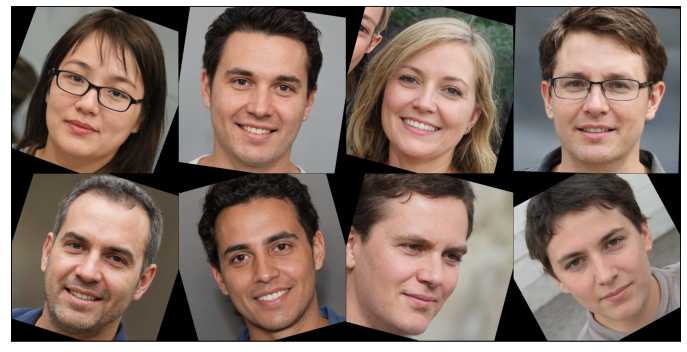

In [6]:
show_batch_color(train_dl_color)

In [7]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), 
                         tt.Resize((48,48)),
                         tt.RandomHorizontalFlip(),          
                         tt.RandomRotation(30),               
                         tt.ToTensor()])                      

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.Resize((48,48)), tt.ToTensor()])

In [29]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Test Classes - {classes_test}')

Test Classes - ['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7', 'no_match']


In [9]:
def digit_to_classname(digit):
    if digit == 0:
        return 'group1'
    elif digit == 1:
        return 'group2'
    elif digit == 2:
        return 'group3'
    elif digit == 3:
        return 'group4'
    elif digit == 4:
        return 'group5'
    elif digit == 5:
        return 'group6'
    elif digit == 6:
        return 'group7'
    elif digit == 6:
        return 'no_match'

In [10]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
test_ds = ImageFolder(data_dir + '/test', test_tfms)

train_ds

Dataset ImageFolder
    Number of datapoints: 4056
    Root location: ./Face_recognition/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=0, pin_memory=True)

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
# show_batch(train_dl)

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cpu')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

#### Модель для распознования лиц

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [16]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

#### Обучаем модель

In [17]:
history = []

epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [18]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

2 epochs, 507 total_steps per epoch


In [19]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in tqdm (enumerate(train_dl)):
        data, labels = Variable(data), Variable(labels)
        data = data.cpu()
        labels = labels.cpu()
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

507it [07:16,  1.16it/s]


Epoch 1, loss:  3.4666223140393018


507it [07:28,  1.13it/s]

Epoch 2, loss:  2.095210723858143


In [20]:
torch.save(model.state_dict(), './models/model_1_batch.pth')

In [22]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('./models/model_1_batch.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

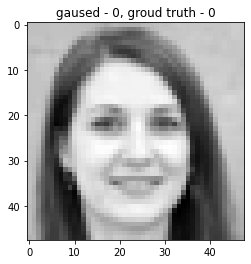

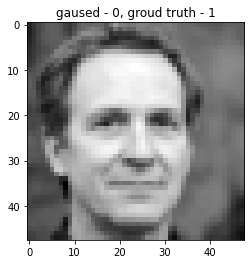

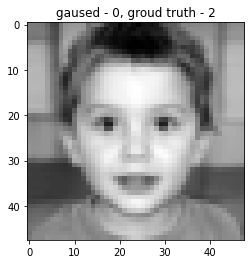

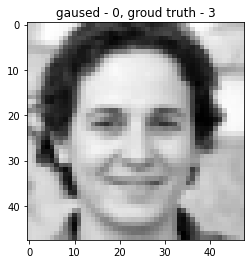

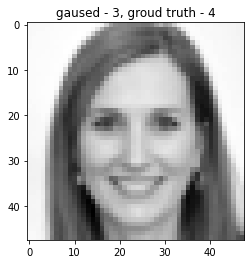

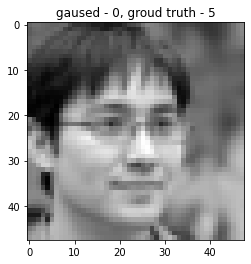

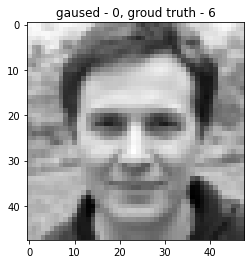

In [28]:
with torch.no_grad():
    for i, data in enumerate(test_dl):
        images, labels = data
        images, labels = Variable(images), Variable(labels)
        outputs = net(images)
        plt.title(f'gaused - {outputs[0].argmax()}, groud truth - {labels[0]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>5:
            break

Думаю с увеличением числа эпох и размера датасета точность возрастёт. Специально было урезано и то и другое чтобы быстрее работало. При сохранении размера фото 1024х1024 выдавало ошибку о недостаточности памяти, также убрал цвет. Качество низкое, но сеть рабочая. 